# Discrete Probabilistic Methods

## Exercise

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

## 1. 

Wrangle Data

In [1]:
from env import get_data
import env

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

In [2]:
# query = """SELECT * FROM api_access"""

# log = get_data('logs', query, 'api_access')

## Stuff the Exercise Gave Us

In [3]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'   
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Make Fake Entries to "detect"

In [4]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])

### Make a size_mb column

In [5]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

### Exploration

In [6]:
df.ip.value_counts().head()

ip
97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: count, dtype: int64

In [7]:
df.ip.value_counts(normalize=True).head()

ip
97.105.19.58      0.858420
173.173.113.51    0.075762
72.181.113.170    0.043855
72.181.105.81     0.017599
68.201.219.223    0.001502
Name: proportion, dtype: float64

In [8]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [9]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
ip,,
97.105.19.58,11999,0.858420
173.173.113.51,1059,0.075762
72.181.113.170,613,0.043855
72.181.105.81,246,0.017599
68.201.219.223,21,0.001502


<Axes: ylabel='ip'>

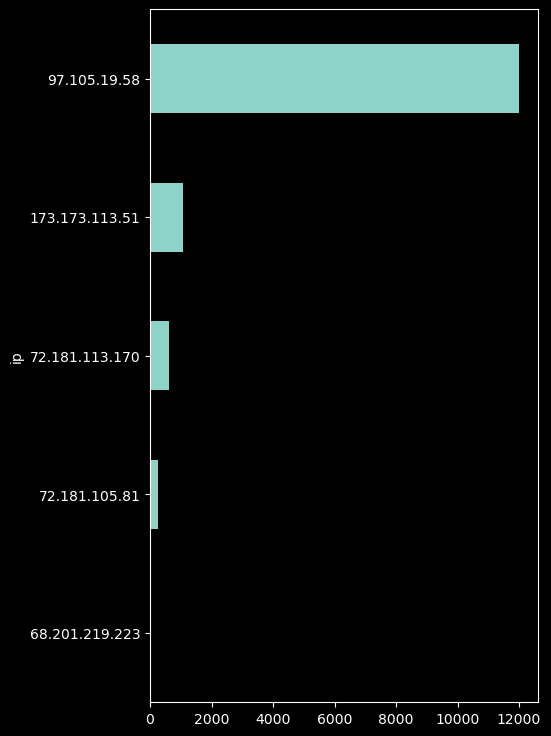

In [10]:
ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))

In [11]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [12]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
19,95.31.16.121,301,1.000000
21,97.105.15.120,301,1.000000
23,97.105.19.58,499,0.001167


In [13]:
df[df.ip == '97.105.15.120']

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-18 19:42:41,97.105.15.120,GET,/api/v1/sales?page=79/,HTTP/1.1,301,2560,python-requests/2.21.0,0.002441


In [14]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
22,97.105.19.58,200,0.998833
23,97.105.19.58,499,0.001167


## My Exploration

Total rows: 13978
Total columns: 8


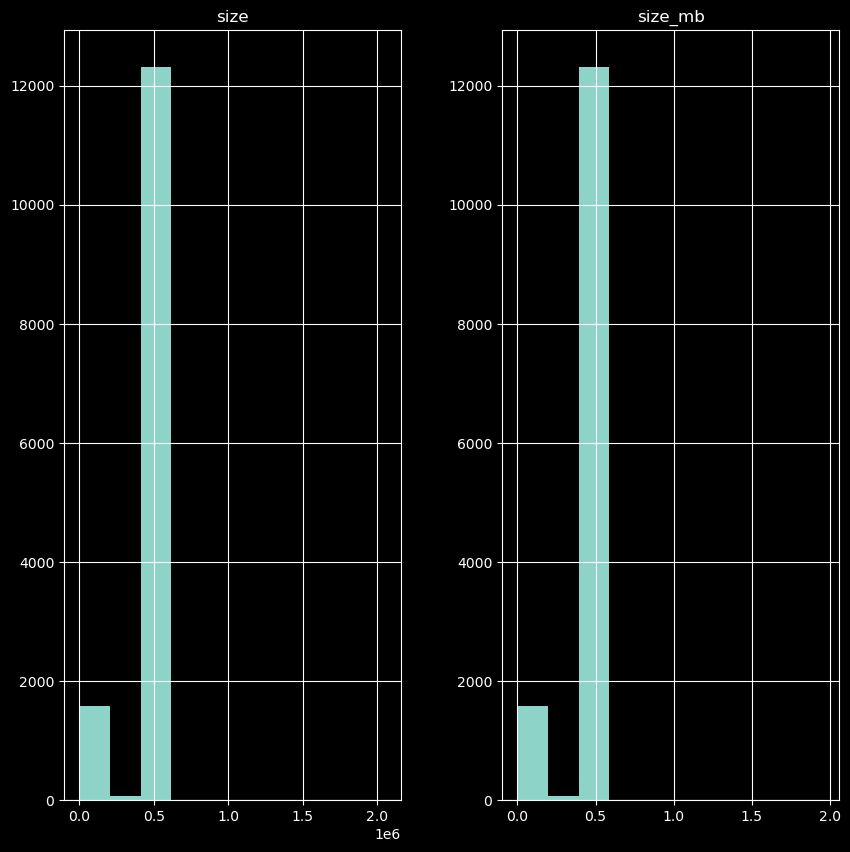

,col_name,dtype,num_unique,num_null,pct_null,unique_values,"range (min, max, mean)"
0,index,datetime64[ns],9957,0,0.0,"DatetimeIndex(['2019-04-16 19:34:42', '2019-04...","(2019-04-16, 2019-04-21)"
1,ip,object,22,0,0.0,"[97.105.19.58, 3.92.201.136, 52.90.165.200, 3....",None
2,request_method,object,1,0,0.0,[GET],None
3,request_path,object,220,0,0.0,"[/api/v1/sales?page=81, /api/v1/items, /api/v1...",None
4,http_version,object,1,0,0.0,[HTTP/1.1],None
5,status_code,object,3,0,0.0,"[200, 499, 301]",None
6,size,int64,191,0,0.0,"[512495, 3561, 510103, 510003, 511963, 1328, 5...","(0, 2056327, 450001.91)"
7,user_agent,object,9,0,0.0,"[python-requests/2.21.0, Mozilla/5.0 (Macintos...",None
8,size_mb,float64,191,0,0.0,"[0.4887533187866211, 0.0033960342407226562, 0....","(0.0, 1.9610662460327148, 0.43)"


In [15]:
env.check_columns(df, graphs=True)

In [16]:
# Make status_desc column
    # 200 = success
    # 499 = client closed request
    # 301 = page permanently moved
    
df['status_desc'] = df.status_code.apply(lambda x: 'success' if x == '200' else 'redirection' if x == '301' else 'client_error')